In [42]:
%matplotlib inline 
import os
import torch
import re
import open_clip
import clip
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

### 对测试集图片生成对应的文本

In [ ]:
device = "cuda:0"
# 配置路径和模型
image_root = "/home/tom/fsas/eeg_data/images/test_images"
output_txt = "descriptions_test.txt"
model_name = "Salesforce/blip2-opt-2.7b"  # 轻量版模型

# 加载模型（显存优化）
processor = Blip2Processor.from_pretrained(model_name)
model = Blip2ForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # 半精度节省显存
    device_map=device           # 自动分配 GPU/CPU
)

# 提取所有子目录并按数字排序
subdirs = []
for dirpath, dirnames, filenames in os.walk(image_root):
    for dirname in dirnames:
        if re.match(r"^\d{5}_", dirname):  # 匹配6位数字前缀
            subdirs.append(os.path.join(dirpath, dirname))

# 按数字前缀排序（例如 00001 → 1）
subdirs.sort(key=lambda x: int(re.search(r"^(\d{5})", os.path.basename(x)).group(1)))

# 批量生成描述并写入文件
with open(output_txt, "w") as f:
    for subdir in subdirs:
        # 提取子目录中的图片文件（仅处理第一个文件）
        image_files = [f for f in os.listdir(subdir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            continue  # 跳过无图片的目录
        image_path = os.path.join(subdir, image_files[0])

        # 加载图像并生成描述
        try:
            image = Image.open(image_path).convert("RGB")
            inputs = processor(images=image, return_tensors="pt").to(model.device, torch.float16)
            generated_ids = model.generate(**inputs, max_new_tokens=100)
            description = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        except Exception as e:
            description = f"ERROR: {str(e)}"

        # 写入文件
        f.write(f"{description}\n")
        print(f"Processed: {os.path.basename(subdir)} → {description[:50]}...")

Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


Processed: 00001_aircraft_carrier → the aircraft carrier is sailing in the ocean...
Processed: 00002_antelope → the antelope is brown...
Processed: 00003_backscratcher → a wooden spoon on a table with a fork...
Processed: 00004_balance_beam → a bench and a wooden bench in a park...
Processed: 00005_banana → three bananas on a white plate...
Processed: 00006_baseball_bat → two baseball bats laying on the grass...
Processed: 00007_basil → a potted basil plant in a greenhouse...
Processed: 00008_basketball → a basketball ball on the court...
Processed: 00009_bassoon → a clarinet on a stand in front of a chair...
Processed: 00010_baton4 → a man holding a yellow stick in his hand...
Processed: 00011_batter → a bowl of batter with a whisk in it...
Processed: 00012_beaver → a beaver is sitting on a skateboard...
Processed: 00013_bench → a wooden bench in the middle of a lush green field...
Processed: 00014_bike → a bicycle is parked on a dirt road in the woods...
Processed: 00015_birthday_cak

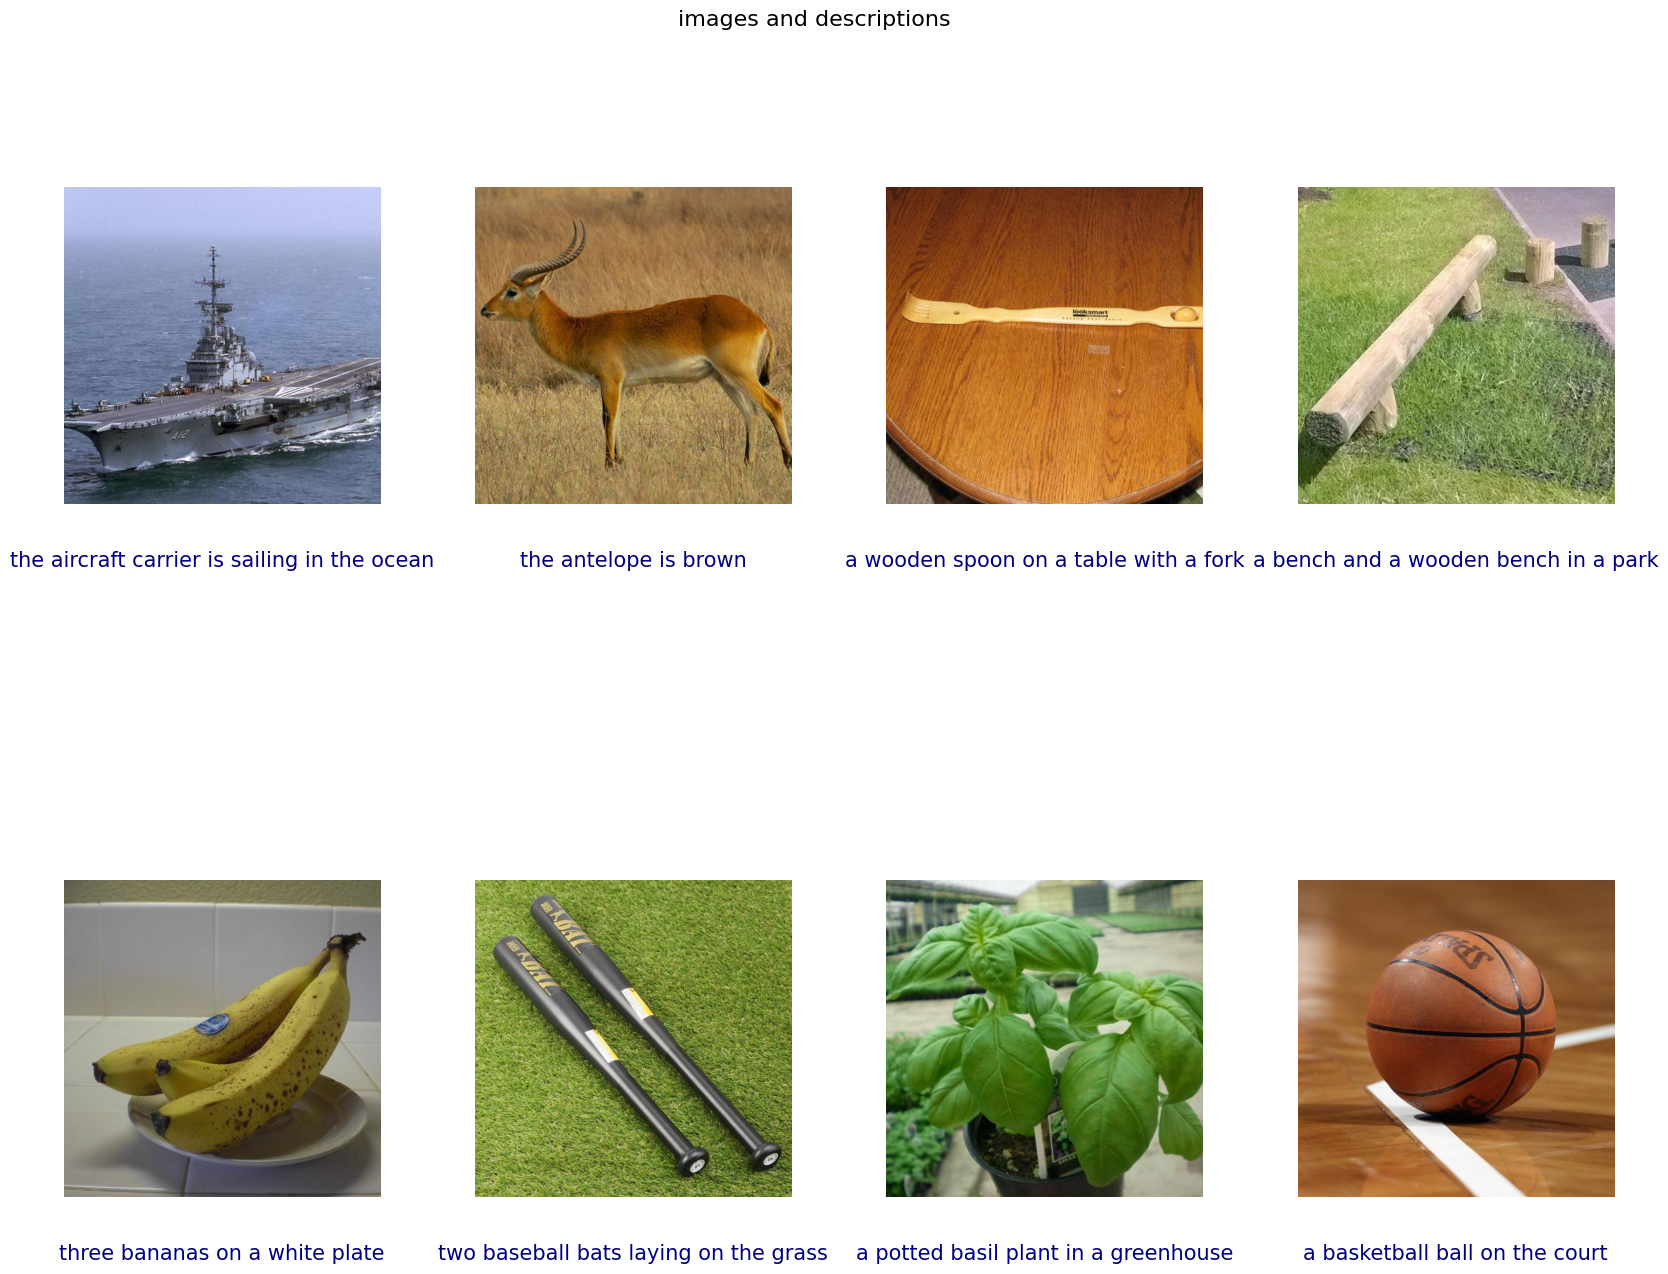

In [ ]:
desc_path = "descriptions_test.txt"
max_display = 8

# 加载生成的描述文本
with open(desc_path, 'r') as f:
    descriptions = [line.strip() for line in f.readlines()[:max_display]]

# 获取前8个子目录的图片路径
subdirs = sorted(
    [d for d in os.listdir(image_root) if re.match(r"^\d{5}_", d)],
    key=lambda x: int(x[:5])
)[:max_display]

image_paths = []
for dirname in subdirs:
    dir_path = os.path.join(image_root, dirname)
    files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    if files:
        image_paths.append(os.path.join(dir_path, files[0]))

# 创建2x4子图画布（适应8张展示）
plt.figure(figsize=(20, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # 调整间距

for i, (img_path, desc) in enumerate(zip(image_paths, descriptions)):
    try:
        # 绘制图像
        ax = plt.subplot(2, 4, i+1)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        
        # 添加描述文本
        plt.text(
            0.5, -0.2, 
            f"{desc}",  # 截断过长的描述
            transform=ax.transAxes, 
            ha='center', 
            fontsize=15,
            color='navy'
        )
    except Exception as e:
        plt.text(
            0.5, 0.5, 
            f"ERROR: {str(e)}", 
            ha='center', 
            color='red'
        )

plt.suptitle("images and descriptions", fontsize=16, y=0.95)
plt.show()

In [ ]:
with open("descriptions_test.txt", "r", encoding="utf-8") as f:
    texts = [line.strip() for line in f] 
print(*texts, sep='\n')

the aircraft carrier is sailing in the ocean
the antelope is brown
a wooden spoon on a table with a fork
a bench and a wooden bench in a park
three bananas on a white plate
two baseball bats laying on the grass
a potted basil plant in a greenhouse
a basketball ball on the court
a clarinet on a stand in front of a chair
a man holding a yellow stick in his hand
a bowl of batter with a whisk in it
a beaver is sitting on a skateboard
a wooden bench in the middle of a lush green field
a bicycle is parked on a dirt road in the woods
a pink birthday cake with lit candles
a can of fire extinguisher sitting on a table
a small blue boat is floating in the water
two pieces of lettuce are sitting on top of a wooden cutting board
a hat with a ribbon and bow on it
personalized wooden bottle opener
a black knee brace with a strap on it
a loaf of bread on a cutting board with a knife
a bread box with bread and a loaf of bread
a brown bug sitting on a green leaf
a man driving an atv on a dirt road
a bu

### 将文本编码并保存为文件

In [37]:
model_type = "ViT-H-14"
vlmodel, _, _ = open_clip.create_model_and_transforms(
    model_type, pretrained="/home/tom/.cache/huggingface/hub/models--laion--CLIP-ViT-H-14-laion2B-s32B-b79K/snapshots/de081ac0a0ca8dc9d1533eed1ae884bb8ae1404b/open_clip_pytorch_model.bin", precision='fp32', device = device)

text_inputs = torch.cat([clip.tokenize(t) for t in texts]).to(device)
            
with torch.no_grad():
    text_features = vlmodel.encode_text(text_inputs)
            
text_features = F.normalize(text_features, dim=-1).detach()

torch.save(text_features, "/home/tom/fsas/eeg_data/features/ATMS_ViT-H-14_text_features_test.pt")

### 对训练集图片生成对应的文本

In [40]:
# 配置路径和模型
device = "cuda:0"
image_root = "/home/tom/fsas/eeg_data/images/training_images"  # 修改为训练集路径
output_txt = "descriptions_train.txt"  # 修改输出文件名
model_name = "Salesforce/blip2-opt-2.7b"

# 加载模型（显存优化）
processor = Blip2Processor.from_pretrained(model_name)
model = Blip2ForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map=device
)

# 提取所有子目录并按数字前缀排序
subdirs = []
for dirpath, dirnames, filenames in os.walk(image_root):
    for dirname in dirnames:
        if re.match(r"^\d{5}_", dirname):  # 匹配5位数字前缀的目录
            subdirs.append(os.path.join(dirpath, dirname))
subdirs.sort(key=lambda x: int(re.search(r"^(\d{5})", os.path.basename(x)).group(1)))

# 批量生成描述并结构化写入
with open(output_txt, "w") as f:
    for subdir in subdirs:
        # 获取目录下所有图片并按文件名排序
        image_files = sorted(
            [f for f in os.listdir(subdir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))],
            key=lambda x: x  # 按文件名自然排序
        )[:10]  # 确保只处理前10张
        
        if not image_files:
            print(f"警告: {subdir} 中无有效图片")
            continue
        
        # 逐张处理并缓存结果
        descriptions = []
        for img_file in image_files:
            image_path = os.path.join(subdir, img_file)
            try:
                image = Image.open(image_path).convert("RGB")
                inputs = processor(images=image, return_tensors="pt").to(model.device, torch.float16)
                generated_ids = model.generate(**inputs, max_new_tokens=100)
                desc = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
            except Exception as e:
                desc = f"ERROR: {str(e)}"
            
            descriptions.append(desc)
            print(f"Processed: {os.path.basename(subdir)}/{img_file} → {desc[:50]}...")
        
        # 写入当前子类别的10行描述
        f.write("\n".join(descriptions) + "\n")

Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


Processed: 00001_aardvark/aardvark_01b.jpg → a small animal with long ears walking on dirt...
Processed: 00001_aardvark/aardvark_02s.jpg → a small armadillo walking on the dirt...
Processed: 00001_aardvark/aardvark_03s.jpg → a baby armadillo in its enclosure at the zoo...
Processed: 00001_aardvark/aardvark_04s.jpg → a small animal walking on the grass...
Processed: 00001_aardvark/aardvark_05s.jpg → a small animal laying on the ground in a dirt area...
Processed: 00001_aardvark/aardvark_06s.jpg → a small animal with large ears standing in the dir...
Processed: 00001_aardvark/aardvark_07s.jpg → a toy armadillo in the grass...
Processed: 00001_aardvark/aardvark_08s.jpg → a small animal walking on the ground near a wooden...
Processed: 00001_aardvark/aardvark_09s.jpg → a small animal with long ears walking on the groun...
Processed: 00001_aardvark/aardvark_10s.jpg → a baby armadillo laying in the grass...
Processed: 00002_abacus/abacus_01b.jpg → an abacus with many beads on it...
Processed

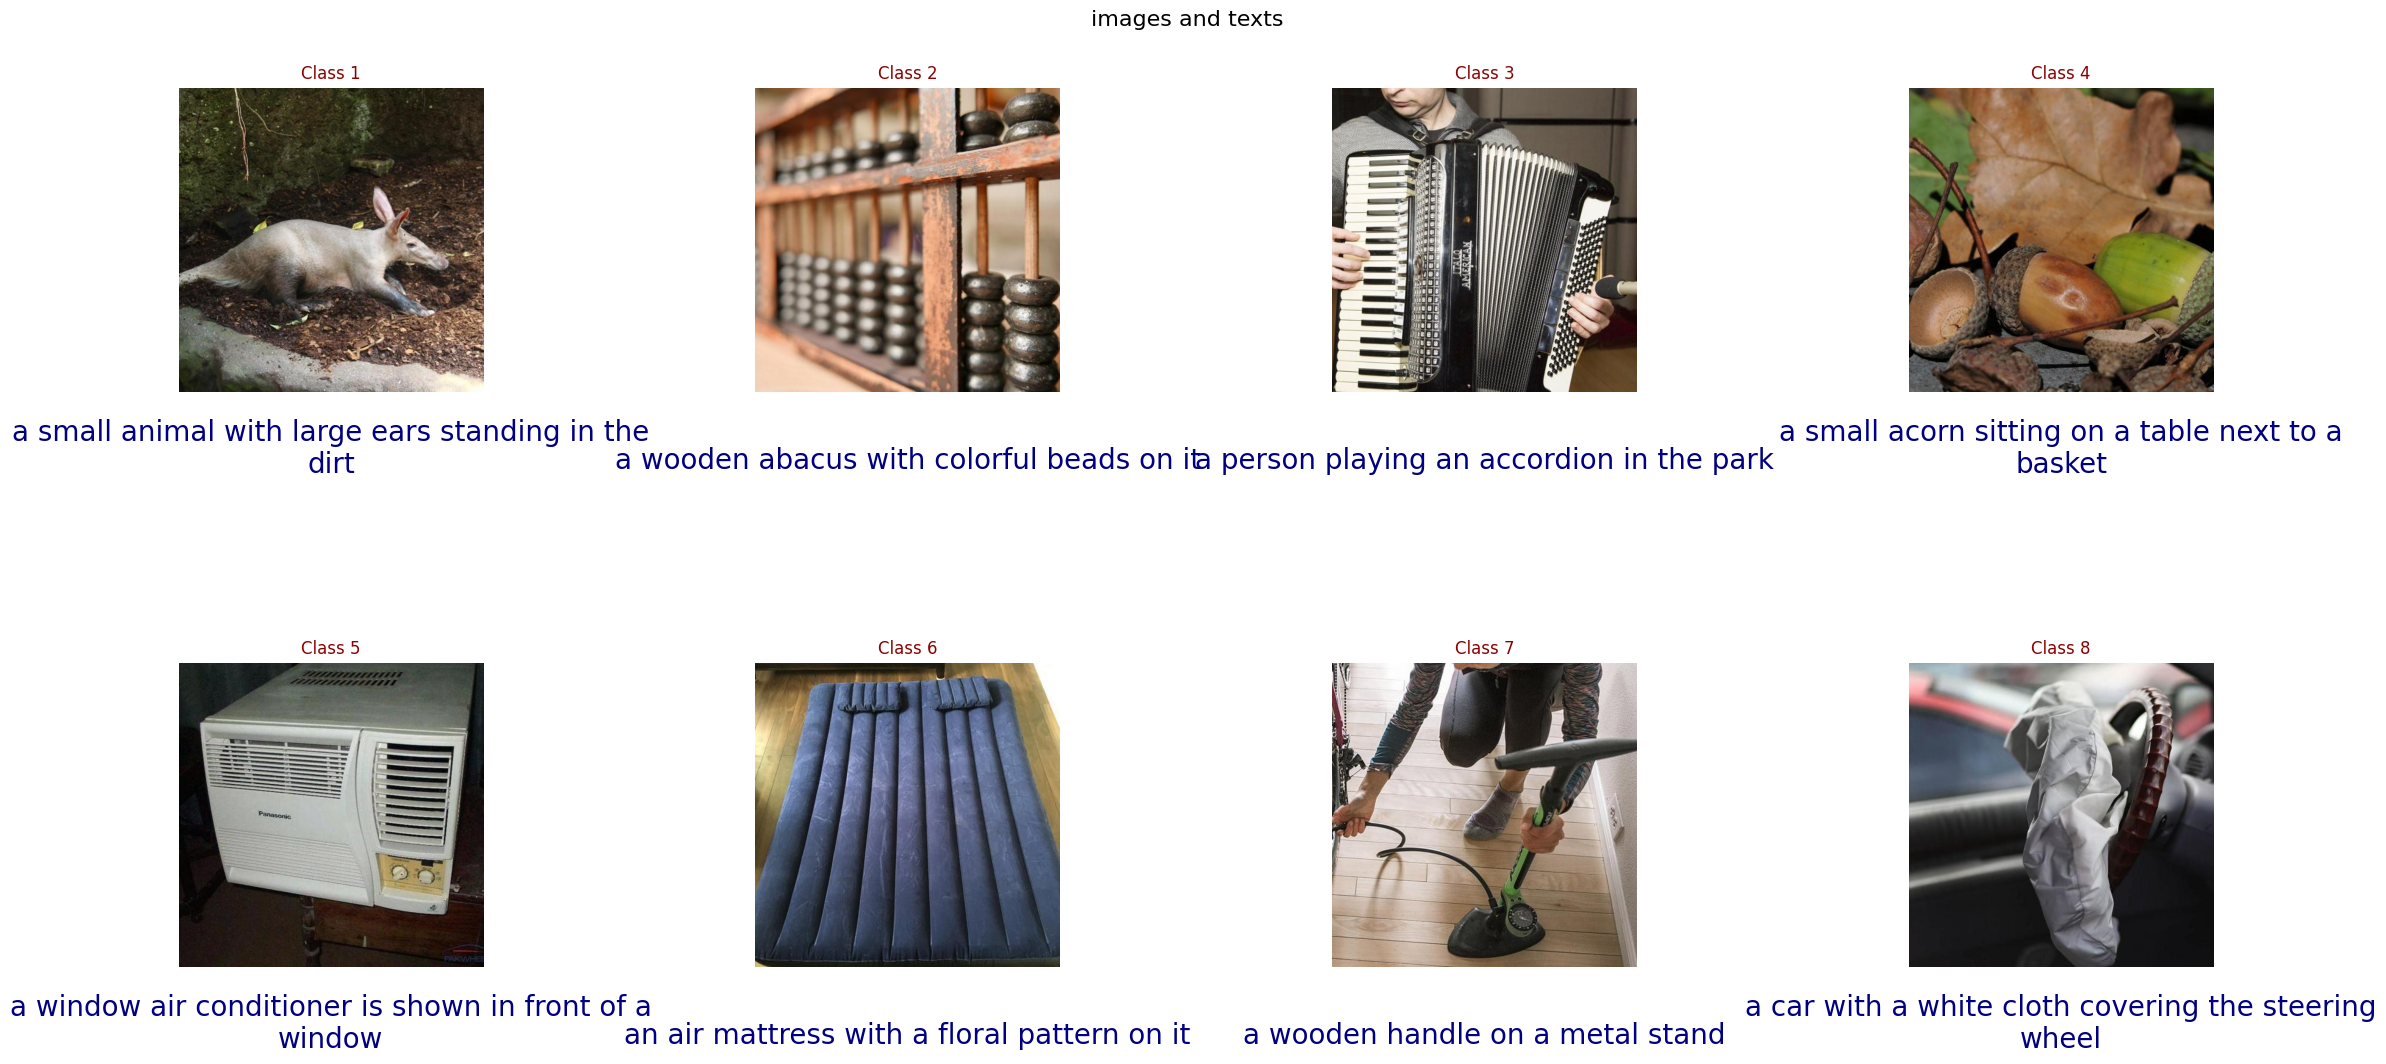

In [ ]:
desc_path = "descriptions_train.txt"
max_display = 8

# 加载描述文本并按类别分组
with open(desc_path, 'r') as f:
    all_descriptions = [line.strip() for line in f.readlines()]
    
# 每10行为一个类别，取前8个类别
descriptions_groups = [all_descriptions[i*10 : (i+1)*10] for i in range(max_display)]

# 获取前8个类别目录并排序
subdirs = sorted(
    [d for d in os.listdir(image_root) if re.match(r"^\d{5}_", d)],
    key=lambda x: int(x[:5])
)[:max_display]

# 创建画布（2行4列布局）
plt.figure(figsize=(24, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.4)  

for idx, (subdir, desc_group) in enumerate(zip(subdirs, descriptions_groups)):
    # 随机选取当前类别的1张图片和1条描述
    selected_desc = random.choice(desc_group)
    dir_path = os.path.join(image_root, subdir)
    image_files = [
        f for f in os.listdir(dir_path) 
        if f.lower().endswith(('.png','.jpg','.jpeg'))
    ]
    selected_img = random.choice(image_files) if image_files else None

    try:
        # 绘制子图
        ax = plt.subplot(2, 4, idx+1)
        if selected_img:
            img_path = os.path.join(dir_path, selected_img)
            img = Image.open(img_path).convert("RGB")
            ax.imshow(img)
            
            # 添加类别ID和描述文本[3](@ref)
            class_id = re.search(r"^(\d{5})", subdir).group(1)
            ax.set_title(f"Class {int(class_id)}", fontsize=12, color='darkred')
            plt.text(
                0.5, -0.25, 
                f"{selected_desc[:70]}..." if len(selected_desc)>70 else selected_desc,
                transform=ax.transAxes, 
                ha='center', 
                fontsize=20,
                color='navy',
                wrap=True  
            )
        else:
            plt.text(0.5, 0.5, "NO IMAGE", ha='center', color='red')
            
        ax.axis('off')
        
    except Exception as e:
        plt.text(0.5, 0.5, f"ERROR: {str(e)}", ha='center', color='red')

plt.suptitle("images and texts", fontsize=16, y=0.95)
plt.tight_layout()  
plt.show()

In [53]:
with open("descriptions_train.txt", "r", encoding="utf-8") as f:
    texts = [line.strip() for line in f] 
print(*texts, sep='\n')

a small animal with long ears walking on dirt
a small armadillo walking on the dirt
a baby armadillo in its enclosure at the zoo
a small animal walking on the grass
a small animal laying on the ground in a dirt area
a small animal with large ears standing in the dirt
a toy armadillo in the grass
a small animal walking on the ground near a wooden door
a small animal with long ears walking on the ground
a baby armadillo laying in the grass
an abacus with many beads on it
an abacus is displayed on a table
a child holding an abacus in front of a blackboard
an abacus is shown in a wooden frame
a young boy holding an abacus in front of him
a wooden abacus with colorful beads on it
a child playing with an abacus toy
a wooden abacus with colorful beads on it
an abacus sitting on top of a table
an abacus with wooden sticks and numbers
a person playing an accordion in the park
a black and white accordion sitting on a floor
a black and gold accordion sitting on a white rug
a wooden accordion sitt

In [55]:
model_type = "ViT-H-14"
vlmodel, _, _ = open_clip.create_model_and_transforms(
    model_type, pretrained="/home/tom/.cache/huggingface/hub/models--laion--CLIP-ViT-H-14-laion2B-s32B-b79K/snapshots/de081ac0a0ca8dc9d1533eed1ae884bb8ae1404b/open_clip_pytorch_model.bin", precision='fp32', device = device)

batch_size = 64  # 根据GPU显存调整
text_features_list = []

# 分batch处理文本
for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    text_inputs = torch.cat([clip.tokenize(t) for t in batch_texts]).to(device)
    
    with torch.no_grad():
        batch_features = vlmodel.encode_text(text_inputs)
        batch_features = F.normalize(batch_features, dim=-1)
        text_features_list.append(batch_features.cpu())  # 移出GPU

# 合并所有batch结果
text_features = torch.cat(text_features_list, dim=0).to(device)
torch.save(text_features, "/home/tom/fsas/eeg_data/features/ATMS_ViT-H-14_text_features_train.pt")

In [56]:
text_features.shape

torch.Size([16540, 1024])